# Fitting Descending time with Cycle Amplitude

When reading the paper https://link.springer.com/article/10.1007/s11207-006-0175-5, and after doing some rudementary analysis on the sunspot data, I decided to see if there was a significant relationship between the solar cycle amplitude and the descending time three cycles earlier.

The data used in this notebook was created in the Sunspot Data Plotting notebook, from the maxima and minima calculated from the SVG smoothed signal of the Sunspot number.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee 
import corner
import pandas as pd

In [2]:
df = pd.read_csv('Data/tmp_dt_polyorder1.csv') # importing data for SVG polyorder = 1
x = df.Descending_Time * 12 # converting time to months
y = df.Solar_Cycle_Maxima
yerr = np.zeros(len(x)) 

**Note:** scatter is so large that errors are completely negligible, thus we have set them equal to 0.

In [3]:
def log_likelihood(theta, x, y, yerr):
    m, b, sig = theta
    model = m * x + b
    sigma2 = sig**2 # changing to account for yerr = 0
    return -0.5 * np.sum((y - model)** 2 / sigma2 + np.log(sigma2))

# Likelihood taken from Linear Regression.ipynb

In [4]:
''' Best linear fit '''
from scipy.optimize import minimize
np.random.seed(42)

nll = lambda *args: -log_likelihood(*args) 
initial = np.array([-1, 180, 50]) + 0.1 * np.random.randn(3) # have no 'true' values, so we put in an arbitrary guess
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, sig = soln.x

print("Maximum likelihood estimates:")
print(f"m = {m_ml:.3f}, b = {b_ml:.3f}, sig = {sig:.3f}")

Maximum likelihood estimates:
m = -1.822, b = 282.345, sig = 39.185


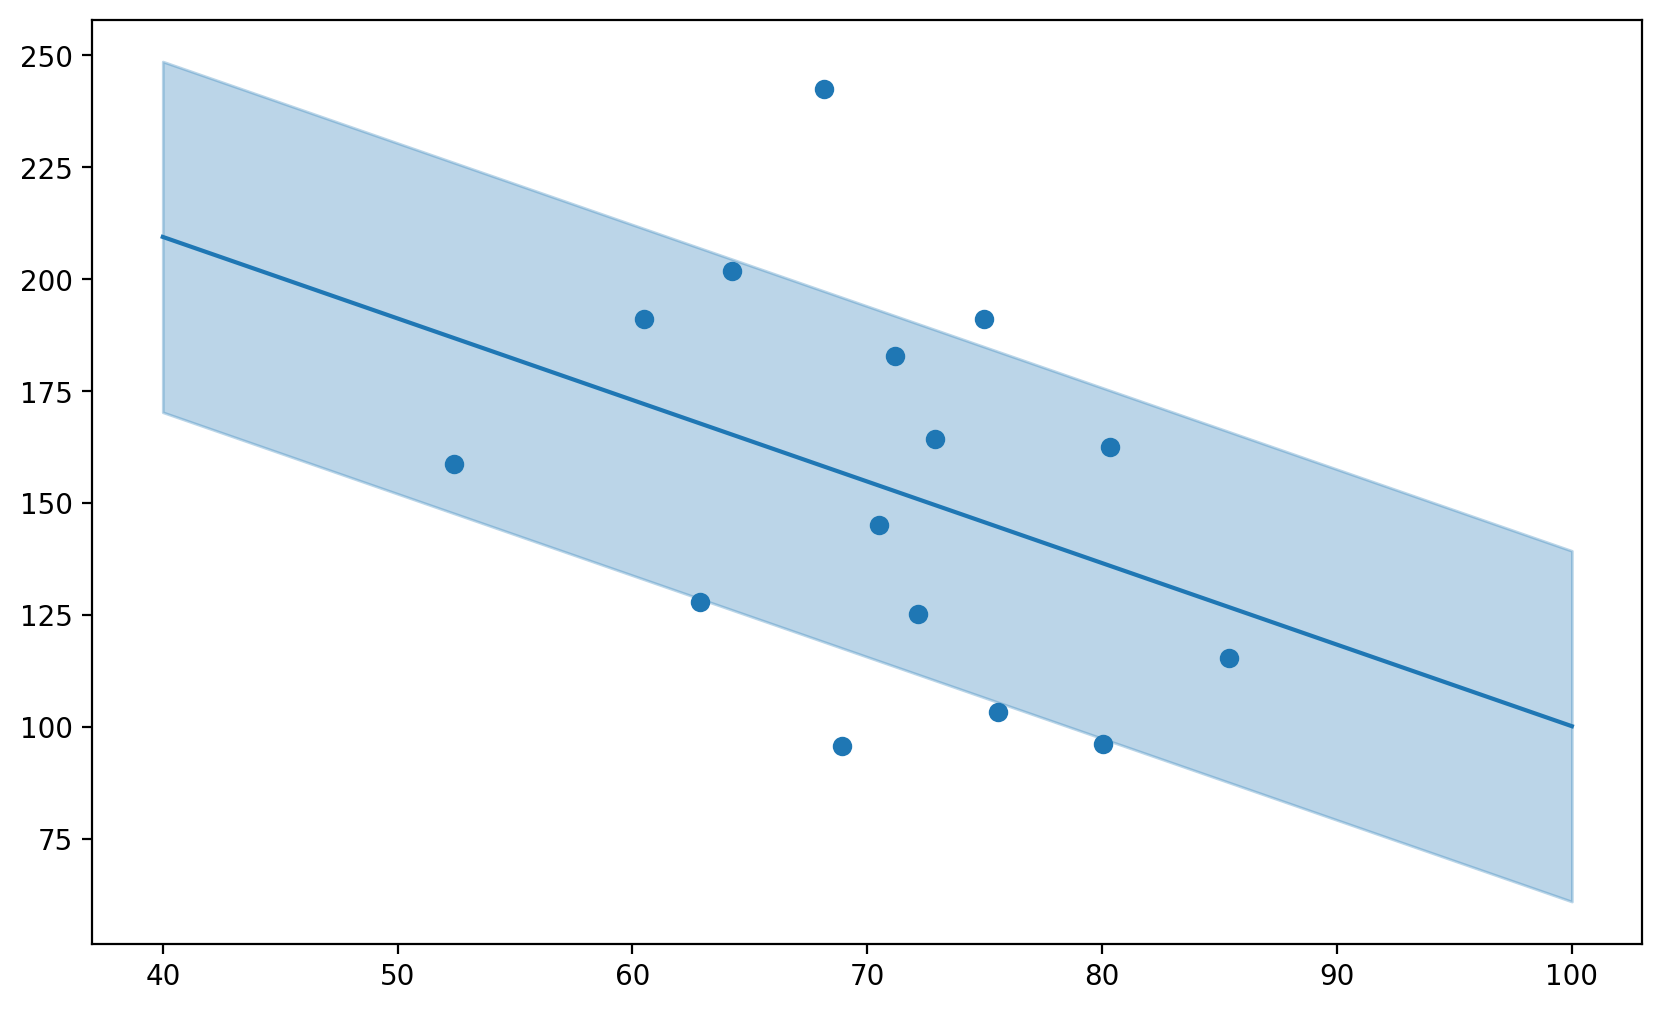

In [21]:
x_new = np.linspace(40, 100)

fig, ax = plt.subplots(dpi=200, figsize=(10,6))
ax.scatter(x, y)
pred = m_ml * x_new + b_ml
ax.plot(x_new, pred) 

ax.fill_between(x_new, pred - sig, pred + sig, alpha = 0.3, color='tab:blue'); # this region shows +- 1 sigma from the best fit

### Comment on plot:
This plot shows that there is a *very weak* linear correlation between cycle amplitude and the descending time three cycles earlier. Just by looking at the points we can see that 40% **do not** lie within 1 standard deviation of the mean. 

From this plot alone I would suggest rejecting the null hypothesis.

## MCMC

To analyse the uncertainty in our data we will be performing the same procedure as was done in the Linear Regression notebook.

In [6]:
def log_prior(theta):
    m, b, sig = theta
    if -20.0 < m < 20.0 and -500.0 < b < 500.0 and 0.0 < sig < 200.0:
        return 0.0
    return -np.inf

In [7]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [8]:
import emcee

pos = soln.x + 1e-5 * np.random.randn(32, 3) # using the MLE model
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [02:14<00:00, 74.28it/s]


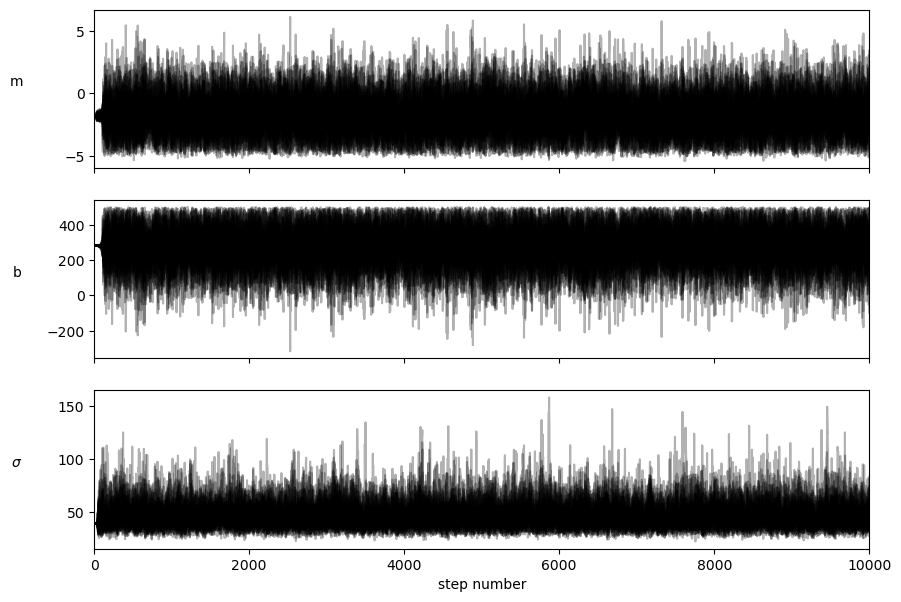

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation = 0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#### Comment on plot:
We can see a perfectly 'noisy' plot, which is exactly what we want. There is the occasional spike at various points, but nothing major. Burn in happens after around 100 points.

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[42.8542962  43.05873478 46.95046157]


In [11]:
flat_samples = sampler.get_chain(discard=150, thin=25, flat=True)
print(flat_samples.shape)

(12608, 3)


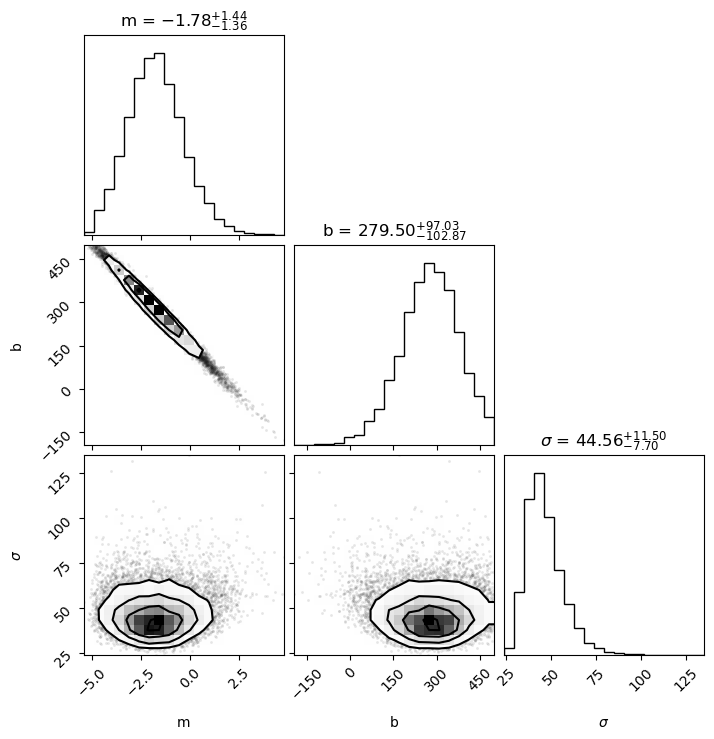

In [63]:
import corner

fig = corner.corner(
    flat_samples, labels=labels,
    show_titles=True
)
fig.savefig('dt_corner.png');

#### Comment on plot:
Looking at the top figure, we see that the probability of $m = 0$ (i.e. no correlation) is not negligible. This suggests that the null hypothesis shouldn't be readily accepted. From this brief analysis we can essentially conclude that the results achieved in the paper are not wholly conclusive, and that there may have been some selection bias involved when picking data to represent the trend.

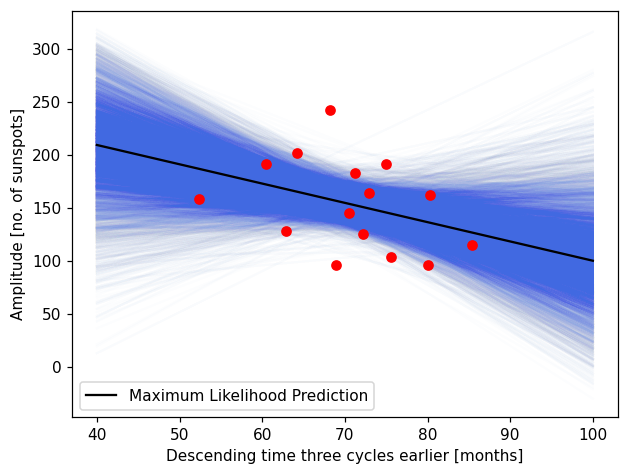

In [62]:
fig, ax = plt.subplots(dpi=110)
ax.scatter(x, y, color='red', zorder=99)

inds = np.random.randint(len(flat_samples), size=7500) 
# which random walk we will be choosing
for ind in inds:
    sample = flat_samples[ind]
    pred2 = sample[0] * x_new + sample[1]
    ax.plot(x_new, pred2, c='royalblue', alpha=0.01) 
ax.plot(x_new, pred, c='black', label='Maximum Likelihood Prediction')
ax.set_xlabel('Descending time three cycles earlier [months]')
ax.set_ylabel('Amplitude [no. of sunspots]')
ax.legend()
fig.savefig('dt_plot.png');

#### Comment on plot:
The dark red region in the middle suggests that there is a high likelihood that our data could fit to any model in this range. The fact that there are even some models which suggest a *positive* gradient (when we calculated a negative one) suggests just how inaccurate the linear fit is with this data. 

The only thing we can conclude is that the data is far too scattered for there to be a statistically significant linear correlation between the cycle amplitude and descending time three cycles earlier.